<a href="https://colab.research.google.com/github/AmirHoseein99/Movie_Recommendation_system/blob/master/Movie_Recommender_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [ ]:
! unzip "/content/drive/MyDrive/lense_movie.zip"

In [3]:
movies = pd.read_csv("/content/movies.csv")
tags = pd.read_csv("/content/tags.csv")
ratings = pd.read_csv("/content/ratings.csv")
links = pd.read_csv("/content/links.csv")

In [4]:
movies = pd.read_csv("/content/movies.csv", index_col="movieId")
print(movies.shape)
movies.head()

(9742, 2)


,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [5]:
movies["genres"] = movies["genres"].apply(lambda x : x.split("|"))
movies["genres"] = movies["genres"].apply(lambda x : ' '.join(word for word in x))
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
2,Jumanji (1995),Adventure Children Fantasy
3,Grumpier Old Men (1995),Comedy Romance
4,Waiting to Exhale (1995),Comedy Drama Romance
5,Father of the Bride Part II (1995),Comedy


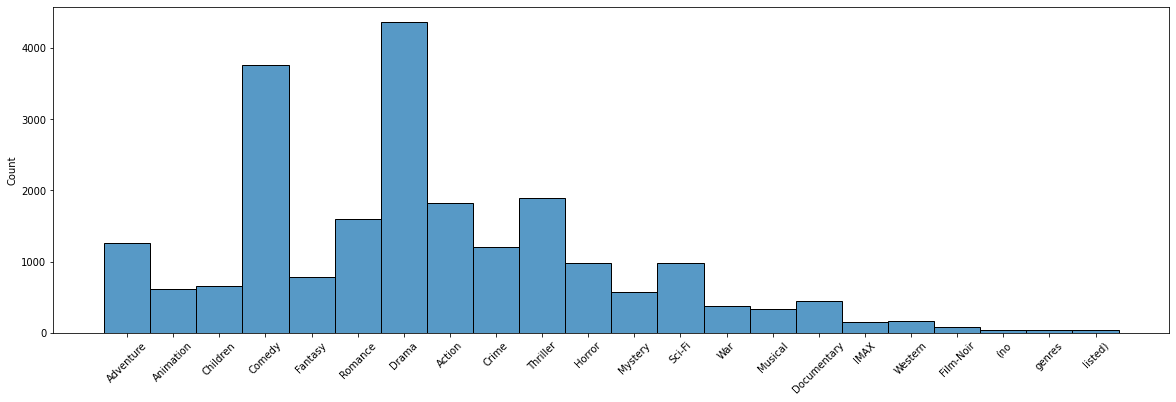

In [6]:
all_genres = [genre for all_genre in movies.genres.to_numpy() for genre in all_genre.split(" ")]
plt.figure(figsize=(20, 6))
_ = sns.histplot(data=all_genres)
_ = plt.xticks(rotation=45)

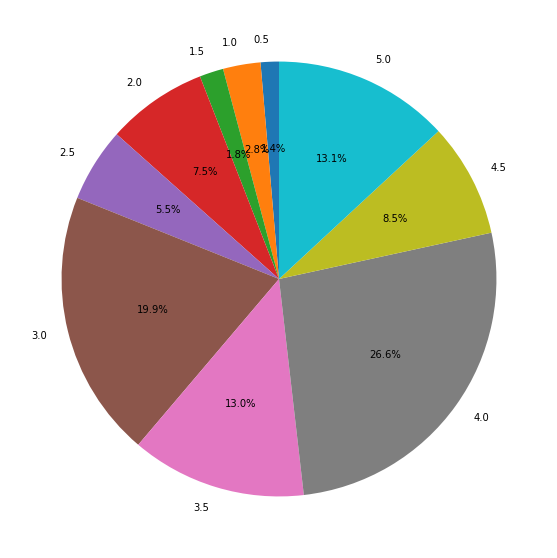

In [58]:
all_rates, counts = np.unique(ratings.rating.to_numpy(), return_counts = True)
plt.figure(figsize=(10, 10))
_=plt.pie(counts, labels=all_rates, autopct='%1.1f%%', startangle=90)

# Content Based
recommend Movise Based On Past interactions of the user with Movies

In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9742 entries, 1 to 193609
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   9742 non-null   object
 1   genres  9742 non-null   object
dtypes: object(2)
memory usage: 228.3+ KB


In [15]:
similarity_feature = movies["genres"].to_numpy()
similarity_feature = np.array([genre.lower() for genre in similarity_feature])
similarity_feature[0]

'adventure animation children comedy fantasy'

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
count_vecotr = CountVectorizer()
count_vecotr.fit(similarity_feature)
similarity_feature = count_vecotr.transform(similarity_feature)

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
movies_similarity = cosine_similarity(similarity_feature)
movies_similarity = pd.DataFrame(movies_similarity)
print(movies_similarity.shape)
movies_similarity.head()

(9742, 9742)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9702,9703,9704,9705,9706,9707,9708,9709,9710,9711,9712,9713,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723,9724,9725,9726,9727,9728,9729,9730,9731,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741
0,1.000000,0.774597,0.316228,0.258199,0.447214,0.0,0.316228,0.632456,0.0,0.258199,0.258199,0.316228,0.774597,0.00000,0.258199,0.000000,0.000000,0.447214,0.447214,0.200000,0.258199,0.000000,0.0,0.000000,0.000000,0.00000,0.316228,0.000000,0.365148,0.000000,0.00000,0.0,0.316228,0.000000,0.632456,0.316228,0.00000,0.000000,0.000000,0.00000,...,0.0,0.316228,0.447214,0.223607,0.223607,0.182574,0.67082,0.223607,0.400000,0.0,0.447214,0.547723,0.000000,0.316228,0.447214,0.774597,0.316228,0.0,0.258199,0.0,0.0,0.258199,0.0,0.000000,0.447214,0.00000,0.00000,0.447214,0.0,0.400000,0.400000,0.316228,0.316228,0.447214,0.0,0.670820,0.774597,0.00000,0.316228,0.447214
1,0.774597,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.816497,0.0,0.333333,0.000000,0.000000,0.666667,0.00000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.408248,0.000000,0.471405,0.000000,0.00000,0.0,0.408248,0.000000,0.408248,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.288675,0.288675,0.235702,0.57735,0.000000,0.516398,0.0,0.288675,0.471405,0.000000,0.000000,0.000000,0.666667,0.000000,0.0,0.333333,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.258199,0.000000,0.000000,0.000000,0.000000,0.0,0.288675,0.333333,0.00000,0.000000,0.000000
2,0.316228,0.000000,1.000000,0.816497,0.707107,0.0,1.000000,0.000000,0.0,0.000000,0.816497,0.500000,0.000000,0.00000,0.408248,0.000000,0.500000,0.707107,0.707107,0.316228,0.408248,0.000000,0.0,0.000000,0.500000,0.00000,0.000000,0.500000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.500000,1.000000,0.00000,0.000000,0.000000,0.00000,...,0.0,0.500000,0.707107,0.000000,0.000000,0.000000,0.00000,0.353553,0.000000,0.0,0.353553,0.288675,0.000000,1.000000,0.707107,0.408248,0.500000,0.0,0.000000,0.0,0.0,0.408248,0.0,0.500000,0.707107,0.00000,0.00000,0.000000,0.0,0.316228,0.316228,0.000000,0.500000,0.000000,0.0,0.353553,0.408248,0.00000,0.000000,0.707107
3,0.258199,0.000000,0.816497,1.000000,0.577350,0.0,0.816497,0.000000,0.0,0.000000,1.000000,0.408248,0.000000,0.57735,0.333333,0.408248,0.816497,0.577350,0.577350,0.516398,0.333333,0.258199,0.0,0.333333,0.816497,0.57735,0.408248,0.816497,0.235702,0.408248,0.57735,0.0,0.408248,0.408248,0.408248,0.816497,0.57735,0.408248,0.333333,0.57735,...,0.0,0.408248,0.577350,0.000000,0.000000,0.235702,0.00000,0.288675,0.000000,0.0,0.288675,0.235702,0.408248,0.816497,0.577350,0.333333,0.816497,0.0,0.000000,0.0,0.0,0.666667,0.0,0.816497,0.577350,0.57735,0.57735,0.000000,0.0,0.258199,0.258199,0.408248,0.816497,0.000000,0.0,0.288675,0.333333,0.57735,0.000000,0.577350
4,0.447214,0.000000,0.707107,0.577350,1.000000,0.0,0.707107,0.000000,0.0,0.000000,0.577350,0.707107,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,1.000000,0.447214,0.577350,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.707107,0.707107,0.00000,0.000000,0.000000,0.00000,...,0.0,0.707107,1.000000,0.000000,0.000000,0.000000,0.00000,0.500000,0.000000,0.0,0.500000,0.408248,0.000000,0.707107,1.000000,0.577350,0.707107,0.0,0.000000,0.0,0.0,0.577350,0.0,0.000000,1.000000,0.00000,0.00000,0.000000,0.0,0.447214,0.447214,0.000000,0.707107,0.000000,0.0,0.500000,0.577350,0.00000,0.000000,1.000000


get Top 10 most similar movies

In [55]:
def get_similar_movies(movie_name):
  movie_id = movies[movies.title == f"{movie_name}"].index[0]
  all_moveis = movies_similarity[movie_id - 1]

  k = 10
  idx = np.argpartition(all_moveis, -k)
  # print(idx[-10:].values)
  most_similar_movies_id = idx[-10:].values
  # np(most_similar_movies_id)
  most_similar_movies_id = np.delete(most_similar_movies_id, np.where(most_similar_movies_id == movie_id - 1)[0])

  for movie_id in most_similar_movies_id :
    print(movies.iloc[movie_id].title)


In [57]:
get_similar_movies("Toy Story (1995)")

Wild, The (2006)
The Good Dinosaur (2015)
Adventures of Rocky and Bullwinkle, The (2000)
Moana (2016)
Turbo (2013)
Antz (1998)
Monsters, Inc. (2001)
Tale of Despereaux, The (2008)
Shrek the Third (2007)


# Collaborative filtering recommender systems

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 1 to 610
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   rating     100836 non-null  float64
 2   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 3.1 MB


In [ ]:
all_users = np.unique(ratings.index.values)
print(all_users.shape)
# all_users.head()

(610,)


In [ ]:
all_rating = pd.DataFrame(np.empty((0, 9743)))
rating_columns = np.append(["userId"], movies.index.values)
all_rating.columns = rating_columns
all_rating = all_rating.set_index('userId')

In [ ]:
all_rating.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [ ]:
ratings.iloc[1]

movieId              3.0
rating               4.0
timestamp    964981247.0
Name: 1, dtype: float64

In [ ]:
for user in all_users:
  moives_rated = ratings.iloc[user][["movieId"]].to_numpy()
  rates = ratings.iloc[user][["rating"]].to_numpy()
  for i in range(len(moives_rated)):
    print(f"user {user} rated movie {moives_rated[i][0]}, {rates[i][0]} score")
    all_rating.at[user, f"{moives_rated[i][0]}"] = rates[i][0]
    # all_rating.append({'User_ID': user, 'UserName': 'Riti', 'Action': 'Login'}, ignore_index=True)
  print("#############################################################################")

IndexError: ignored

In [ ]:
all_rating.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,93193,93598,93819,94867,96832,97188,97285,97701,97988,98061,98633,99030,99721,100159,100397,100579,100906,102066,102070,102338,102760,102802,103085,103219,103483,103685,105801,107436,107447,107462,107771,110281,110286,110591,110746,111551,112727,113159,113313,113565
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
all_rating.shape

(610, 19427)

In [ ]:
all_rating = all_rating.dropna(thresh = 100)
all_rating.shape

(176, 19427)

In [ ]:
all_rating.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,93193,93598,93819,94867,96832,97188,97285,97701,97988,98061,98633,99030,99721,100159,100397,100579,100906,102066,102070,102338,102760,102802,103085,103219,103483,103685,105801,107436,107447,107462,107771,110281,110286,110591,110746,111551,112727,113159,113313,113565
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.0,NaN,4.0,5.0,3.0,5.0,4.0,4.0,3.0,NaN,3.0,4.0,NaN,3.0,NaN,4.0,4.0,4.0,NaN,2.0,NaN,2.0,5.0,NaN,4.0,3.0,4.0,3.0,NaN,NaN,NaN,3.0,4.0,4.0,5.0,NaN,NaN,NaN,4.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18.0,3.5,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from sklearn.impute import SimpleImputer
simpute = SimpleImputer(strategy="median")
all_rating= simpute.fit_transform(all_rating)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sims = cosine_similarity(all_rating)
cosine_sims = pd.DataFrame(cosine_sims)

In [ ]:
print(cosine_sims.shape)
cosine_sims.head()

(176, 176)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175
0,1.000000,0.997258,0.997569,0.997769,0.998304,0.995798,0.997863,0.996885,0.995917,0.998182,0.997027,0.996915,0.997522,0.997244,0.996532,0.997360,0.997869,0.997637,0.997872,0.997985,0.993396,0.998042,0.998461,0.998356,0.997948,0.998178,0.995860,0.996877,0.998444,0.997965,0.997960,0.997780,0.995730,0.998055,0.998471,0.998170,0.998038,0.997913,0.997169,0.997850,...,0.995929,0.996695,0.997734,0.995152,0.997474,0.997747,0.998132,0.993107,0.998232,0.997952,0.997697,0.998081,0.997419,0.998066,0.996876,0.998155,0.997481,0.998136,0.998405,0.998235,0.995149,0.998352,0.998124,0.997562,0.998336,0.996691,0.997871,0.998035,0.997406,0.996616,0.998136,0.997456,0.991395,0.994402,0.994198,0.998089,0.997061,0.997908,0.995069,0.996852
1,0.997258,1.000000,0.997236,0.997639,0.997888,0.995586,0.997376,0.996584,0.996076,0.997836,0.996811,0.996468,0.996856,0.997082,0.996144,0.997109,0.997365,0.997412,0.997358,0.997455,0.993604,0.997677,0.998130,0.997953,0.997574,0.997866,0.995748,0.996663,0.997958,0.997425,0.997731,0.997450,0.995690,0.997595,0.998192,0.997794,0.997374,0.997489,0.997072,0.997430,...,0.995573,0.996354,0.997167,0.995018,0.996972,0.997527,0.997842,0.993201,0.997905,0.997662,0.997441,0.997506,0.996968,0.997818,0.996164,0.997780,0.997144,0.997670,0.998059,0.997885,0.994880,0.998042,0.997686,0.996985,0.998017,0.996086,0.997331,0.997607,0.997333,0.996109,0.997826,0.996722,0.991238,0.994395,0.994169,0.997899,0.996747,0.997571,0.994946,0.996276
2,0.997569,0.997236,1.000000,0.997731,0.998151,0.995734,0.997643,0.996885,0.996151,0.998112,0.997104,0.996898,0.997214,0.997256,0.996590,0.997235,0.997730,0.997507,0.997761,0.997914,0.993956,0.997973,0.998361,0.998291,0.997824,0.998277,0.995979,0.996638,0.998238,0.997881,0.997969,0.997667,0.995812,0.998002,0.998596,0.998113,0.997719,0.997823,0.997320,0.997748,...,0.995869,0.996692,0.997586,0.995117,0.997412,0.997803,0.998105,0.993278,0.998184,0.997900,0.997760,0.997914,0.997366,0.998002,0.996702,0.998133,0.997372,0.998028,0.998389,0.998169,0.995257,0.998355,0.998082,0.997428,0.998295,0.996610,0.997824,0.998102,0.997373,0.996805,0.998168,0.996950,0.990930,0.994486,0.994418,0.998150,0.997061,0.997944,0.995028,0.996709
3,0.997769,0.997639,0.997731,1.000000,0.998522,0.996208,0.997832,0.997057,0.996390,0.998462,0.997331,0.997081,0.997320,0.997491,0.996917,0.997601,0.997895,0.998008,0.997977,0.998127,0.994042,0.998226,0.998645,0.998561,0.998116,0.998454,0.996295,0.997240,0.998530,0.998108,0.998245,0.997890,0.996001,0.998207,0.998709,0.998328,0.998054,0.998150,0.997786,0.998009,...,0.996025,0.997124,0.997714,0.995730,0.997468,0.998141,0.998364,0.993750,0.998488,0.998177,0.998076,0.998134,0.997583,0.998404,0.996708,0.998308,0.997746,0.998277,0.998634,0.998492,0.995572,0.998709,0.998337,0.997659,0.998609,0.996777,0.997977,0.998254,0.997877,0.996800,0.998437,0.997251,0.991855,0.995107,0.994869,0.998407,0.997328,0.998141,0.995437,0.996903
4,0.998304,0.997888,0.998151,0.998522,1.000000,0.996696,0.998372,0.997528,0.996887,0.998890,0.997844,0.997568,0.997942,0.998023,0.997316,0.998132,0.998631,0.998295,0.998453,0.998686,0.994462,0.998777,0.999168,0.999087,0.998626,0.998928,0.996780,0.997621,0.999051,0.998667,0.998769,0.998518,0.996513,0.998750,0.999211,0.998856,0.998596,0.998573,0.998057,0.998470,...,0.996628,0.997497,0.998202,0.996131,0.998008,0.998587,0.998833,0.993961,0.998958,0.998736,0.998506,0.998571,0.998085,0.998866,0.997220,0.998872,0.998222,0.998787,0.999169,0.998961,0.995853,0.999105,0.998872,0.998049,0.999014,0.997401,0.998523,0.998797,0.998290,0.997271,0.998847,0.997838,0.992358,0.995430,0.995297,0.998867,0.997848,0.998574,0.996082,0.997413


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sims = cosine_similarity(all_rating.T)
cosine_sims = pd.DataFrame(cosine_sims)

In [ ]:
print(cosine_sims.shape)
cosine_sims.head()

(18725, 18725)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,18685,18686,18687,18688,18689,18690,18691,18692,18693,18694,18695,18696,18697,18698,18699,18700,18701,18702,18703,18704,18705,18706,18707,18708,18709,18710,18711,18712,18713,18714,18715,18716,18717,18718,18719,18720,18721,18722,18723,18724
0,1.000000,0.981675,0.979196,0.987271,0.981378,0.981525,0.981592,0.985752,0.986477,0.975564,0.982235,0.982355,0.986312,0.986545,0.981498,0.981844,0.984096,0.985465,0.971209,0.985759,0.979480,0.981863,0.985292,0.985666,0.980064,0.987331,0.985503,0.985605,0.984993,0.985283,0.984766,0.981023,0.981875,0.982509,0.986082,0.979579,0.986967,0.986459,0.986759,0.977675,...,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959,0.986959
1,0.981675,1.000000,0.982972,0.987688,0.986425,0.986485,0.983248,0.987728,0.987204,0.979727,0.984663,0.984904,0.988795,0.988658,0.985843,0.984619,0.983050,0.988970,0.978212,0.988967,0.982922,0.984399,0.987610,0.984816,0.982211,0.989292,0.987321,0.987832,0.987612,0.986572,0.986397,0.982702,0.979998,0.984686,0.988044,0.979923,0.989054,0.988159,0.988322,0.981713,...,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864,0.988864
2,0.979196,0.982972,1.000000,0.988293,0.986711,0.986023,0.986247,0.987460,0.986928,0.976820,0.985438,0.983095,0.987408,0.988646,0.988831,0.985938,0.982949,0.987190,0.973932,0.990237,0.981385,0.987174,0.987760,0.987554,0.982230,0.989911,0.987204,0.988074,0.986654,0.987426,0.986118,0.982138,0.979341,0.985098,0.988145,0.982037,0.989553,0.987430,0.989499,0.978247,...,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971,0.988971
3,0.987271,0.987688,0.988293,1.000000,0.993085,0.994117,0.991240,0.997699,0.998412,0.988282,0.993003,0.992722,0.998356,0.998930,0.994845,0.995076,0.993072,0.996581,0.980181,0.997528,0.992527,0.994276,0.996748,0.994322,0.992690,0.998662,0.997170,0.998334,0.996235,0.997681,0.996198,0.990223,0.988206,0.995264,0.998025,0.989342,0.998797,0.998338,0.998586,0.987328,...,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291,0.999291
4,0.981378,0.986425,0.986711,0.993085,1.000000,0.989600,0.988759,0.991744,0.992452,0.983321,0.989037,0.986796,0.993024,0.993676,0.992631,0.990426,0.987382,0.993463,0.975005,0.991573,0.985401,0.990520,0.991429,0.989010,0.986701,0.993529,0.992906,0.993006,0.990877,0.991725,0.990251,0.984547,0.982185,0.990272,0.993640,0.983167,0.993189,0.993009,0.993410,0.981434,...,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326,0.993326
